# **Model Evaluation**

## Objectives

* Evaluate the performance of the optimized Gradient Boosting and XGBRegressor models.
* Analyze feature importance to understand which variables have the most influence on house prices.
* Ensure that the chosen model meets the business requirement (R2 ≥ 0.75)

## Inputs

* The prepared dataset (`HousePricesFeatures.csv`)
* Libraries for machine learning and data handling, including:
  - **pandas** for data manipulation.
  - **sklearn** for machine learning and model training.
  - **matplotlib** and **seaborn** for visualizations.
  - **joblib** for saving and loading models.


## Outputs

* The optimized XGBRegressor model is saved as: jupyter_notebooks/outputs/best_model/best_xgboost_model.pkl.
* Visualization of feature importance.
* Model evaluation metrics (MSE, R2).
* Conclusions regarding the model's performance and usability.


___

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues'

___

### Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from joblib import dump 
from xgboost import XGBRegressor

# Load data

In [2]:
# Load the selected features dataset
df_selected = pd.read_csv("outputs/datasets/collection/HousePricesPredictionFeatures.csv")

# Confirm the dataset is loaded correctly
print("Dataset loaded successfully.")
print(df_selected.head())

# Load the saved pipeline
pipeline = joblib.load("outputs/pipelines/feature_pipeline.pkl")
print("Pipeline loaded successfully.")


Dataset loaded successfully.
   GrLivArea  OverallQual  TotalBsmtSF  YearRemodAdd  GarageArea  SalePrice
0     1710.0            7        856.0          2003  204.517915   208500.0
1     1262.0            6       1262.0          1976  177.329636   181500.0
2     1786.0            7        920.0          2002  222.579733   223500.0
3     1717.0            7        756.0          1970  232.664362   140000.0
4     2198.0            8       1145.0          2000  288.451992   250000.0
Pipeline loaded successfully.


In [8]:
# Define features (X) and target (y) from df_selected
X = df_selected.drop(columns=['SalePrice'])  # Exclude SalePrice as it is the target
y = df_selected['SalePrice']  # Define SalePrice as the target variable

# Train-test split with features and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Confirm the shapes of training and testing datasets
print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Testing target shape: {y_test.shape}")

Training features shape: (1022, 5)
Testing features shape: (438, 5)
Training target shape: (1022,)
Testing target shape: (438,)


##### **Gradient Boosting Regressor optimization**

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100, model__subsample=0.8; total time=   0.8s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100, model__subsample=1.0; total time=   0.7s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100, model__subsample=0.8; total time=   0.7s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100, model__subsample=0.8; total time=   0.8s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100, model__subsample=0.8; total time=   0.7s
[CV] END model__learning_rate=0.01, model__max_dept

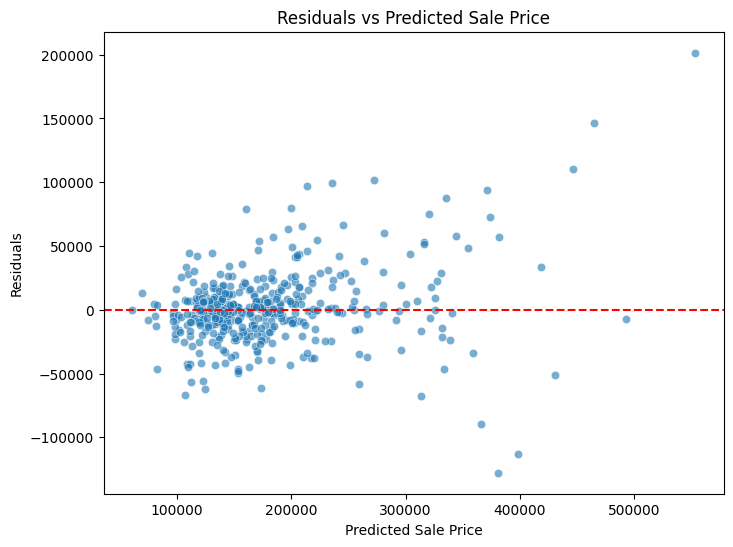

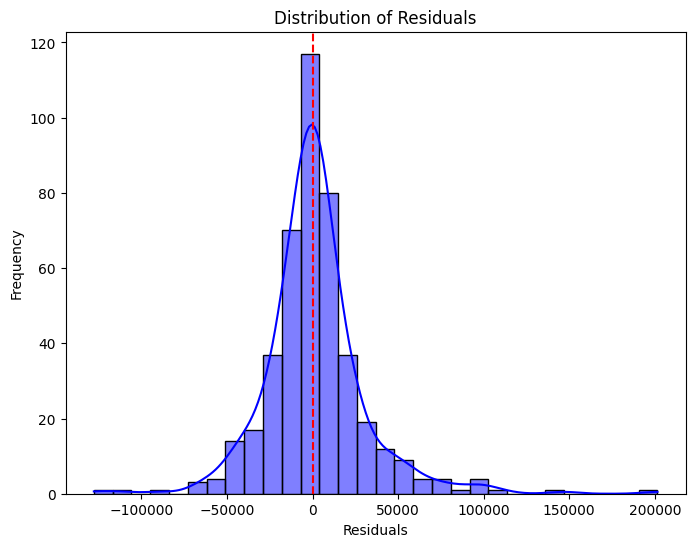

In [19]:
pipeline = Pipeline([
    ('model', GradientBoostingRegressor(random_state=42))  # Model to train
])

# Define the parameters for randomized search
param_grid = {
    'model__n_estimators': [100, 200, 300, 400],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [3, 5, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__subsample': [0.8, 1.0]
}

# Perform grid search for hyperparameters
grid_search = GridSearchCV(
    pipeline, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='r2'
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found and evaluate the model
print(f"Best hyperparameters from grid search: {grid_search.best_params_}")

# Retrieve the optimized model
optimized_model = grid_search.best_estimator_

# Make predictions with the optimized model
y_pred_optimized = optimized_model.predict(X_test)

# Calculate metrics without log-transformation
mse_optimized = mean_squared_error(y_test, y_pred_optimized)
r2_optimized = r2_score(y_test, y_pred_optimized)

print(f"Optimized MSE: {mse_optimized}")
print(f"Optimized R2 Score: {r2_optimized}")

# Residuals vs Predicted Sale Price
residuals = y_test - y_pred_optimized
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_optimized, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Sale Price")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Sale Price")
plt.show()

# Distribution of Residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color='blue')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.show()


##### **XGBRegressor optimization**

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[CV] END model__colsample_bytree=0.8, model__gamma=0, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__subsample=1.0; total time=   0.2s
[CV] END model__colsample_bytree=0.8, model__gamma=0, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__subsample=0.8; total time=   0.2s
[CV] END model__colsample_bytree=0.8, model__gamma=0, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__subsample=0.8; total time=   0.2s
[CV] END model__colsample_bytree=0.8, model__gamma=0, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__subsample=0.8; total time=   0.2s
[CV] END model__colsample_bytree=0.8, model__gamma=0, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__subsample=0.8; total time=   0.2s
[CV] END model__colsample_bytree=0.8, model__gamma=0, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=200, model__subsample=1.0; total time=   0.3

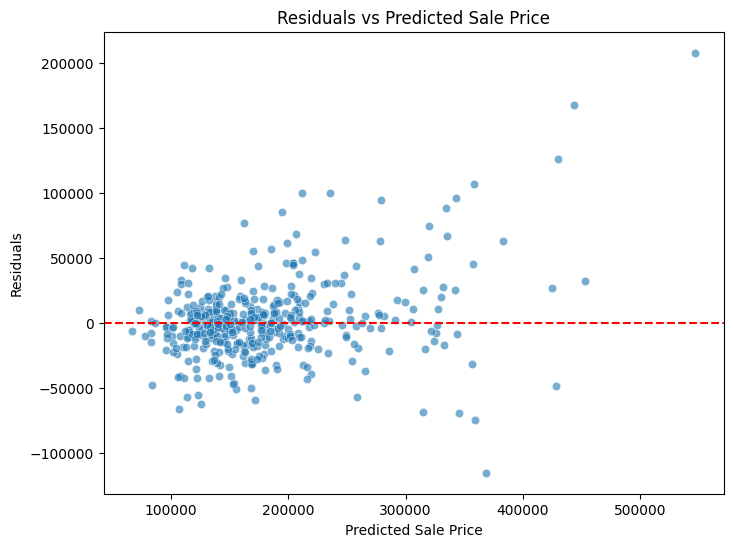

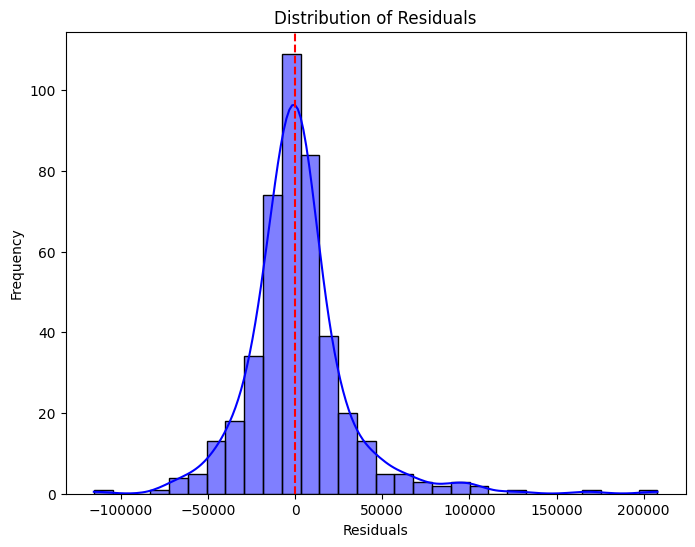

In [17]:
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('model', XGBRegressor(random_state=42))  # Model to train
])

# Define the parameters for randomized search
param_grid = {
    'model__n_estimators': [100, 200, 300, 400],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [3, 5, 10, 20],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0],
    'model__gamma': [0, 1, 5]
}


# Perform grid search for hyperparameters
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found and evaluate the model
print(f"Best hyperparameters from grid search: {grid_search.best_params_}")

# Retrieve the optimized model
optimized_model = grid_search.best_estimator_

# Make predictions with the optimized model
y_pred_optimized = optimized_model.predict(X_test)

# Calculate metrics without inverse log-transformation
mse_optimized = mean_squared_error(y_test, y_pred_optimized)
r2_optimized = r2_score(y_test, y_pred_optimized)

print(f"Optimized MSE: {mse_optimized}")
print(f"Optimized R2 Score: {r2_optimized}")


# Residual analysis
residuals = y_test - y_pred_optimized

# Residuals vs Predicted Sale Price
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_optimized, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Sale Price")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Sale Price")
plt.show()

# Histogram of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True, color='blue')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.show()

#### **Conclusion:**

Both models worked well, but **XGBRegressor** performed slightly better than **Gradient Boosting Regressor**.

- **R² Score**:
  - **XGBRegressor**: 0.8223
  - **Gradient Boosting**: 0.8180

  **XGBRegressor** explains more of the variation in house prices.

- **Mean Squared Error (MSE)**:
  - **XGBRegressor**: 0.0301
  - **Gradient Boosting**: 0.0308

  **XGBRegressor** has a lower error, meaning its predictions are closer to the actual prices.

#### **Decision**:
Both models had similar results and were well above the requirement of >0.75 R2.
Since **XGBRegressor** performs slightly better, it is chosen as the final model for predicting house prices.




In [18]:
# Save the optimized Gradient Boosting model
dump(optimized_model, 'outputs/best_model/best_gradient_boosting_model.pkl')
print("Gradient Boosting model saved successfully.")

# Save the XGBoost model
dump(xgb_model, 'outputs/best_model/best_xgboost_model.pkl')
print("XGBoost model saved successfully.")

Gradient Boosting model saved successfully.
XGBoost model saved successfully.


___

### Visualizing Optimized Gradient Boosting Regressor Performance

The following visualizations show how well the optimized Gradient Boosting Regressor predicts house prices:

1. **Actual vs Predicted Sale Price**: This scatter plot compares the actual sale prices with the predicted sale prices. Points close to the red line indicate good predictions.
2. **Residuals vs Predicted Sale Price**: This plot shows the residuals (errors) for each prediction. Residuals centered around zero indicate a well-performing model.

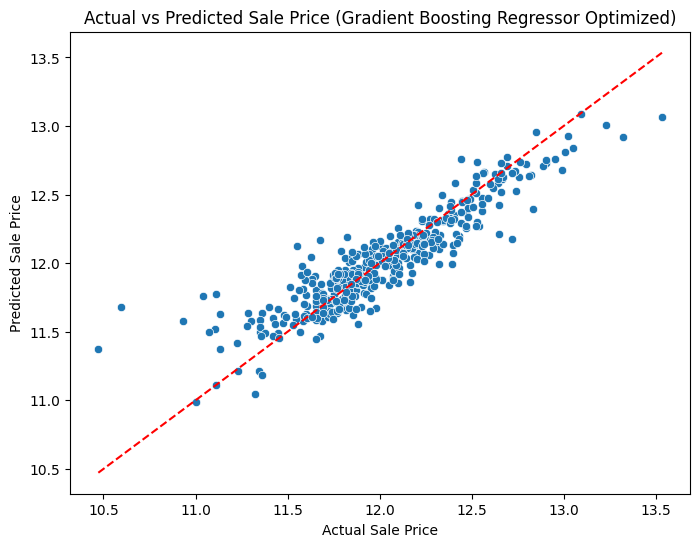

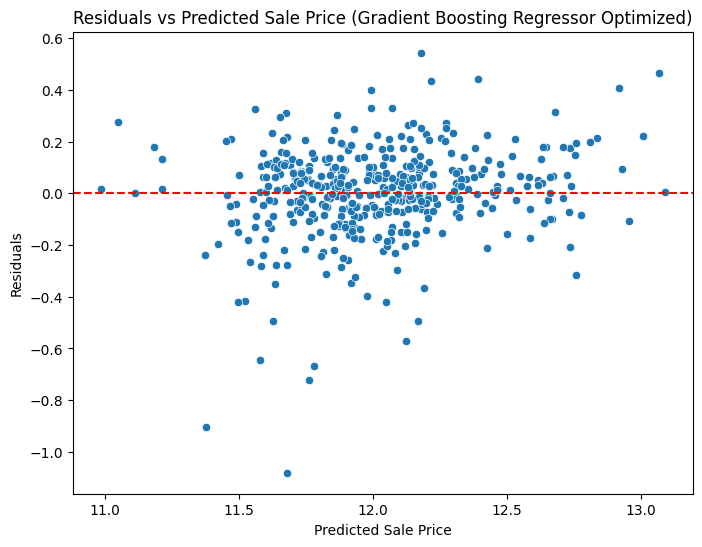

Model used for predictions: Gradient Boosting Regressor


In [19]:
# After optimization of Gradient Boosting

optimized_model = random_search.best_estimator_ 
y_pred_optimized = optimized_model.predict(X_test)  # Predicted values after optimization
model_name = "Gradient Boosting Regressor"  # Model name for the plot

# Plot predicted vs actual values after optimization
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_optimized, alpha=0.6)  # Scatter plot of actual vs predicted values
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], color='red', linestyle='--')  # Diagonal line for perfect prediction
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title(f"Actual vs Predicted Sale Price ({model_name} Optimized)")
plt.show()

# Scatter plot of residuals vs predicted values
residuals_optimized = y_test - y_pred_optimized  # Calculate residuals
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_optimized, y=residuals_optimized, alpha=0.6)  # Scatter plot of residuals vs predicted values
plt.axhline(y=0, color='red', linestyle='--')  # Horizontal line at y = 0 for residuals
plt.xlabel("Predicted Sale Price")
plt.ylabel("Residuals")
plt.title(f"Residuals vs Predicted Sale Price ({model_name} Optimized)")
plt.show()

print(f"Model used for predictions: {model_name}")

The plots look good overall. The "Actual vs Predicted" plot shows that most predictions are close to the line, indicating the model performs well. The "Residuals vs Predicted" plot shows that residuals are mostly centered around zero, with no obvious pattern, suggesting the model doesn't have systematic errors. There are a few outliers on more expensive houses, but overall, these visualizations provide a clear summary of the model's performance after optimization.